Timetracking:
- 24.06.21 20:00-20:30 Load model and data
- 25.06.21 08:30-10:00 Generate SHAP values and analyze feature importance
- 27.06.21 07:20-08:00 Feature Effects

total: 2:40

# Explain the decision boundary of a machine learning model

In [1]:
import pandas as pd
import joblib
import shap
from shap.maskers import Independent
import matplotlib.pyplot as plt
from comparers import plot_decision_boundary, _encode_one_hot, _calc_log_odds_from_log_proba
from explainers import SameTypeExplanationsNamespace, calc_feature_order, calc_class_order, calc_instance_order, plot_2d, \
                       plot_feature_importance_bar, plot_feature_importance_scatter, plot_feature_effects, plot_forces, \
                       merge_explanations
import numpy as np
import pandas as pd
import pickle
shap.initjs()
%matplotlib inline
task_name = '01'

In [2]:
try:
    with open(task_name + '.expl', 'rb') as f:
        explanations = pickle.load(f)
    print('loaded cached state')
except FileNotFoundError:
    pass

loaded cached state


## Load model and data

In [3]:
X = pd.read_csv('test_data.csv')
y = X['price']
X = X.drop(columns=['Unnamed: 0', 'price'])
X

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
0,5.438165,0.0,18.100000,0.713000,6.395536,2.0,2.331054,24.000000,666.000000,20.200000,16.525663
1,10.062300,0.0,18.100000,0.584000,6.833000,2.0,2.088200,24.000000,666.000000,20.200000,19.690000
2,0.402020,0.0,9.900000,0.544000,6.382000,1.0,3.532500,4.000000,304.000000,18.400000,10.360000
3,0.290900,0.0,21.890000,0.624000,6.174000,2.0,1.611900,4.000000,437.000000,21.200000,24.160000
4,0.250659,0.0,9.542886,0.532534,5.743817,1.0,4.153345,3.880564,295.520027,18.340282,12.371885
...,...,...,...,...,...,...,...,...,...,...,...
241,6.801170,0.0,18.100000,0.713000,6.081000,1.0,2.717500,24.000000,666.000000,20.200000,14.700000
242,0.402820,0.0,6.200000,0.504000,8.137837,2.0,3.169809,8.000000,307.000000,17.400000,3.344242
243,3.774980,0.0,18.100000,0.655000,5.952000,1.0,2.871500,24.000000,666.000000,20.200000,17.150000
244,0.344745,0.0,21.890000,0.624000,5.685295,2.0,1.814662,4.000000,437.000000,21.200000,17.348228


In [4]:
feature_names = X.columns.to_numpy()
feature_names

array(['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'LSTAT'], dtype=object)

In [5]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 246 entries, 0 to 245
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     246 non-null    float64
 1   ZN       246 non-null    float64
 2   INDUS    246 non-null    float64
 3   NOX      246 non-null    float64
 4   RM       246 non-null    float64
 5   AGE      246 non-null    float64
 6   DIS      246 non-null    float64
 7   RAD      246 non-null    float64
 8   TAX      246 non-null    float64
 9   PTRATIO  246 non-null    float64
 10  LSTAT    246 non-null    float64
dtypes: float64(11)
memory usage: 21.3 KB


In [9]:
y.describe()

count    246.000000
mean       1.020325
std        0.825359
min        0.000000
25%        0.000000
50%        1.000000
75%        2.000000
max        2.000000
Name: price, dtype: float64

In [10]:
class_names = y.unique().astype(str)
class_names

array(['0', '1', '2'], dtype='<U21')

In [11]:
clf_a = joblib.load('model_A.joblib')

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [12]:
clf_a.classes_

array([0, 1, 2], dtype=int32)

In [14]:
hasattr(clf_a, 'predict_proba'), hasattr(clf_a, 'predict_log_proba')

(True, True)

In [14]:
y_pred = clf_a.predict(X)
y_pred

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 1, 2, 0, 0, 2, 1, 2, 1, 2,
       1, 1, 1, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 0, 1, 0, 2, 1, 0, 0, 0, 2,
       0, 0, 0, 2, 2, 2, 2, 1, 2, 0, 2, 1, 1, 0, 1, 2, 0, 2, 1, 2, 0, 2,
       0, 1, 1, 0, 2, 0, 2, 2, 0, 2, 0, 2, 1, 1, 1, 0, 2, 2, 0, 2, 0, 1,
       2, 0, 1, 0, 2, 1, 2, 0, 0, 2, 2, 2, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2,
       1, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2,
       1, 0, 1, 0, 0, 2, 2, 0, 1, 2, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 2,
       1, 0, 1, 0, 1, 1, 1, 2, 2, 0, 1, 2, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2,
       2, 0, 2, 2, 0, 2, 0, 2, 0, 1, 2, 1, 0, 1, 1, 1, 0, 2, 0, 1, 0, 2,
       2, 0, 2, 1, 0, 0, 2, 2, 1, 2, 1, 0, 1, 2, 2, 0, 1, 2, 0, 2, 0, 0,
       2, 2, 1, 2, 0, 1, 0, 0, 2, 1, 2, 2, 2, 2, 0, 0, 1, 2, 0, 0, 1, 0,
       2, 0, 0, 0], dtype=int32)

Knowing this, we can analyze probabilities in probability space or log odds space.

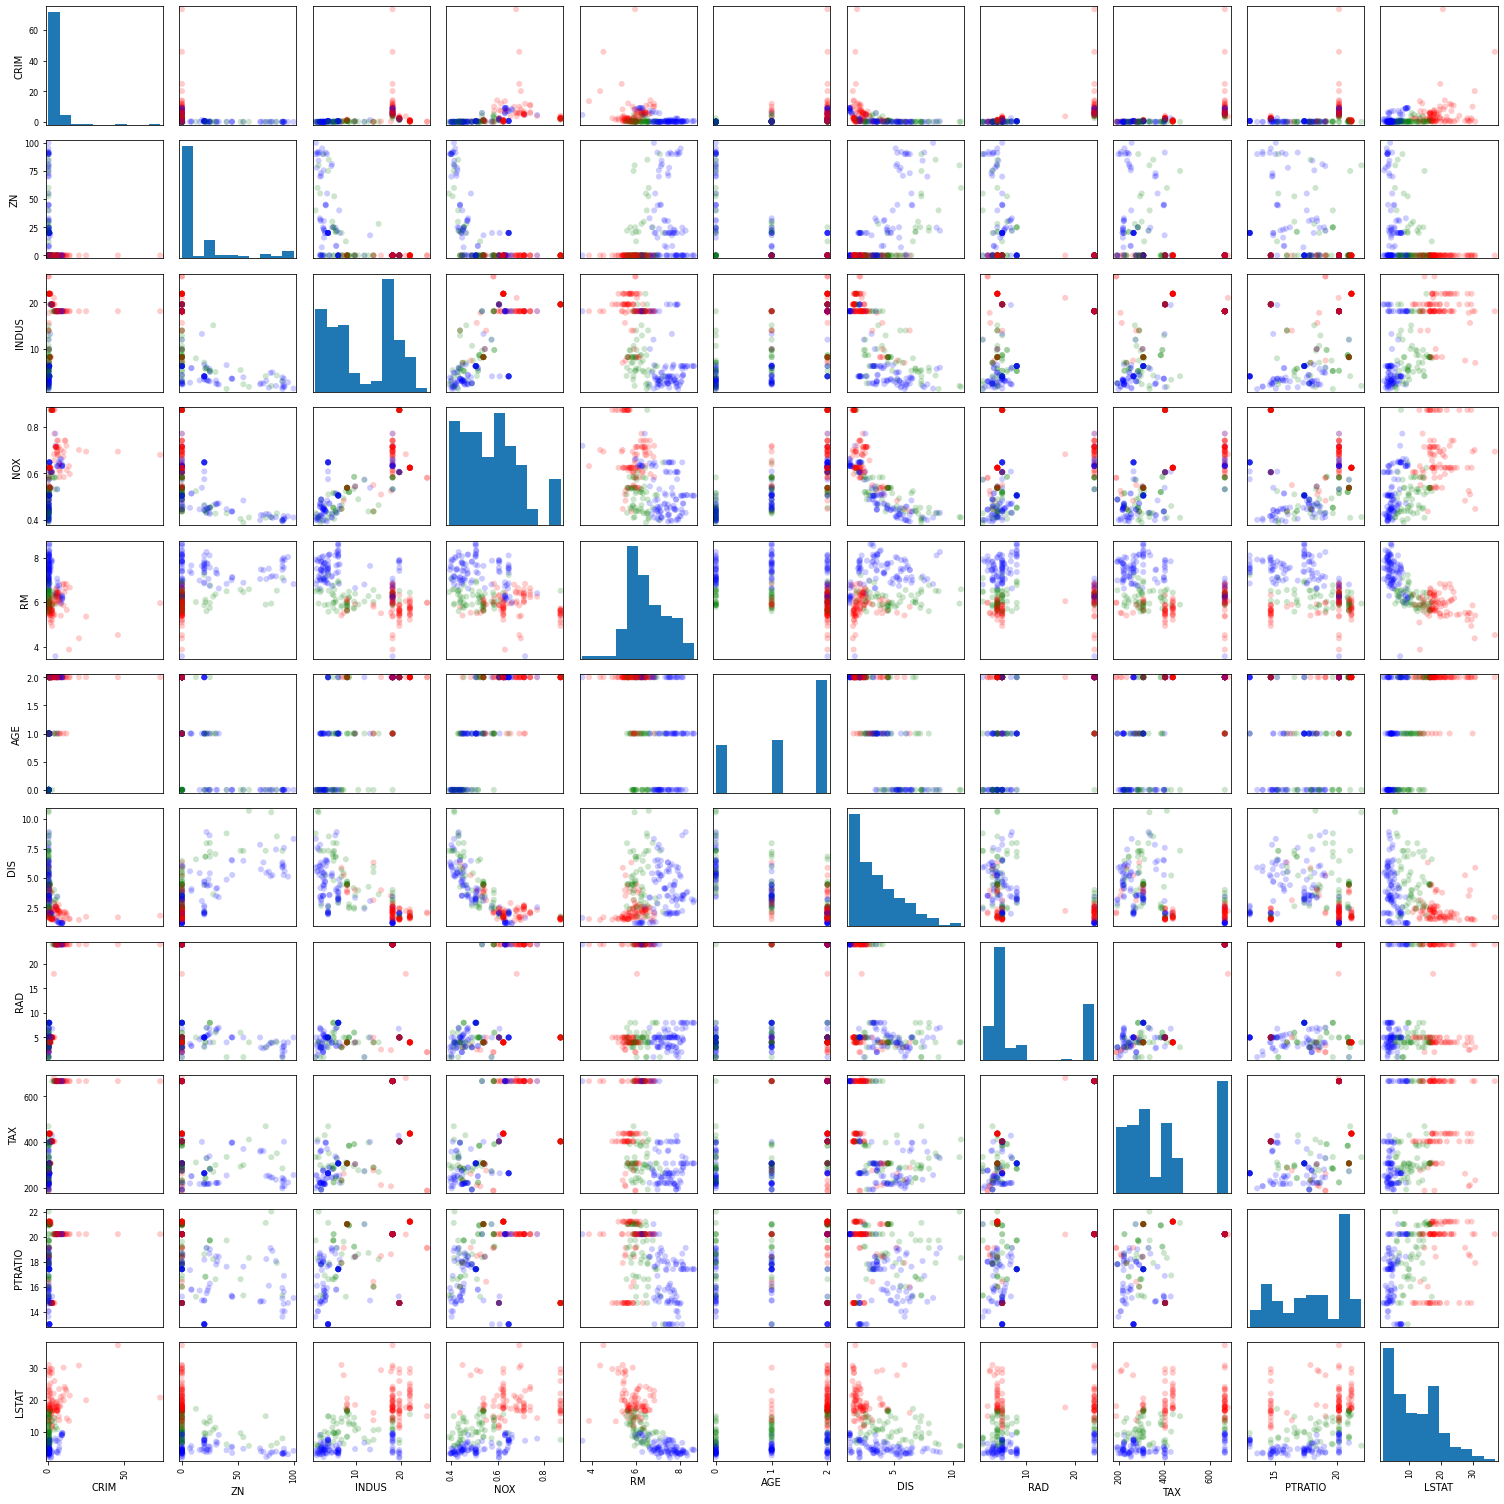

In [16]:
df = pd.DataFrame(X, columns=feature_names)
colors = np.repeat('r', df.shape[0])
colors[y_pred == 1] = 'g'
colors[y_pred == 2] = 'b'
axes = pd.plotting.scatter_matrix(df, figsize=(21, 21), marker='o', alpha=0.2, c=colors)
plt.tight_layout()

## Generate SHAP values

For this small tabular dataset, we will use the default independent masker. It masks out features in the perturbations phase by replacing values with values from the background data set, for which we will use the whole test dataset.

In [19]:
predict_labels = lambda X: _encode_one_hot(clf_a.predict(X), clf_a.classes_)
predict_log_odds = lambda X: _calc_log_odds_from_log_proba(clf_a.predict_log_proba(X))

In [21]:
masker = Independent(data=X, max_samples=X.shape[0])
explainer = shap.Explainer(predict_labels, masker=masker, feature_names=feature_names)
shap_values_labels = explainer(X)

Permutation explainer: 247it [00:21,  8.14it/s]                         


In [29]:
explainer = shap.Explainer(clf_a.predict_proba, masker=masker, feature_names=feature_names)
shap_values_proba = explainer(X)

Permutation explainer: 247it [00:15,  5.52it/s]                         


In [30]:
explainer = shap.Explainer(predict_log_odds, masker=masker, feature_names=feature_names)
shap_values_log_odds = explainer(X)

Permutation explainer: 247it [00:18,  5.90it/s]                         


Now we need to work around a bug in the shap permutation explainer, and set the class names manually:

In [46]:
make_shap_values_with_class_names = lambda shap_values, class_names:\
    shap.Explanation(shap_values.values, shap_values.base_values, shap_values.data, shap_values.display_data,
                     shap_values.instance_names, shap_values.feature_names, output_names=class_names)
shap_values_labels = make_shap_values_with_class_names(shap_values_labels, class_names)
shap_values_proba = make_shap_values_with_class_names(shap_values_proba, class_names)
shap_values_log_odds = make_shap_values_with_class_names(shap_values_log_odds, class_names)

Finally, check if all SHAP values in log-odds space are finite (sometimes they go to infinity):

In [47]:
is_finite = np.all(np.all(np.isfinite(shap_values_log_odds.values), axis=2), axis=1)
np.sum(~is_finite)

0

Finally, we put them in a sliceable container and store them:

In [48]:
explanations = SameTypeExplanationsNamespace(labels=shap_values_labels,
                                             proba=shap_values_proba,
                                             log_odds=shap_values_log_odds)
with open(task_name + '.expl', 'wb') as f:
    pickle.dump(explanations, f, pickle.HIGHEST_PROTOCOL)

## Global Explanations

### Feature importance

We will check all available explanation spaces to assess the importance of each feature, measured in terms of the mean absolute of its SHAP values.

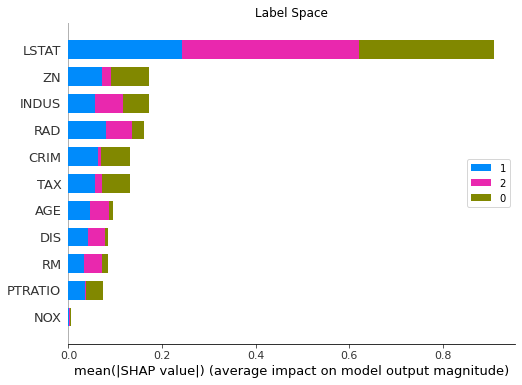

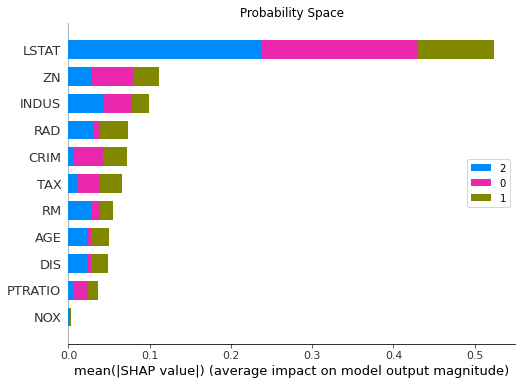

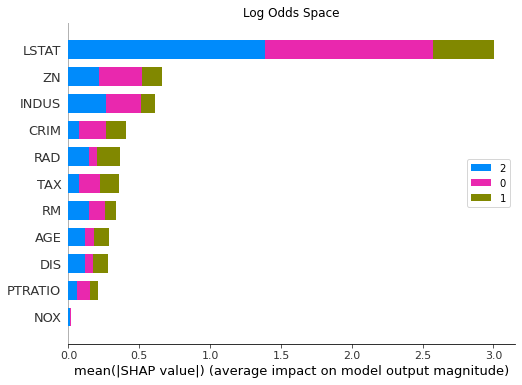

In [13]:
plot_feature_importance_bar(explanations.labels, title='Label Space')
plot_feature_importance_bar(explanations.proba, title='Probability Space')
plot_feature_importance_bar(explanations.log_odds, title='Log Odds Space')

The ranking is fairly similar across spaces. We notice, that LSTAT is of much higher importance to all classes than the second ranked feature, ZN. Next, we will use the log odds space to derive a feature order from this ranking and plot the unaggregated SHAP values for each feature, to see the whole distribution.

In [29]:
feature_order, _ = calc_feature_order(explanations.log_odds)

For feature LSTAT, we see a clear picture. For instances with high feature values it increases the odds for class 0, while it decreases them for low values. It's the opposite for class 2. class 1 seems to be indefinite.

In [30]:
class_order = np.arange(len(explanations.output_names))

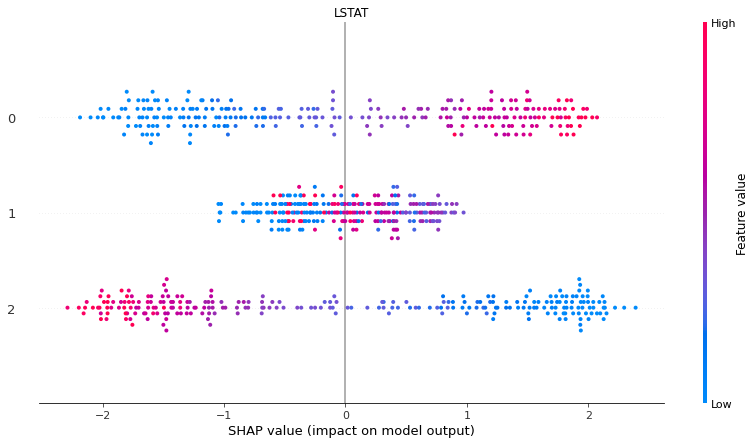

In [5]:
plot_feature_importance_scatter(explanations.log_odds[:, [feature_order[0]]], class_order=class_order)

For feature ZN, we see that for instances with high values this feature increases the odds for class 2 / decreases the odds for class 0 quite drastically (-1 log odds equals appr. -70% probability), but for the majority, which has low feature values, it has a smaller opposite effect. Again, the scatter plot for class 1 does not seem to contain that much structure.

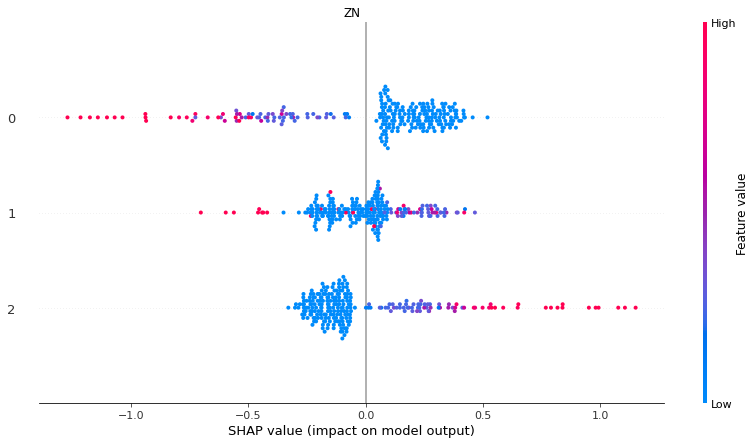

In [6]:
plot_feature_importance_scatter(explanations.log_odds[:, [feature_order[1]]], class_order=class_order)

Regarding the third ranked feature INDUS, we see a very similar picture compared to LSTAT, just with lower SHAP values. Possibly, these are the inherent characteristics of this classifier.

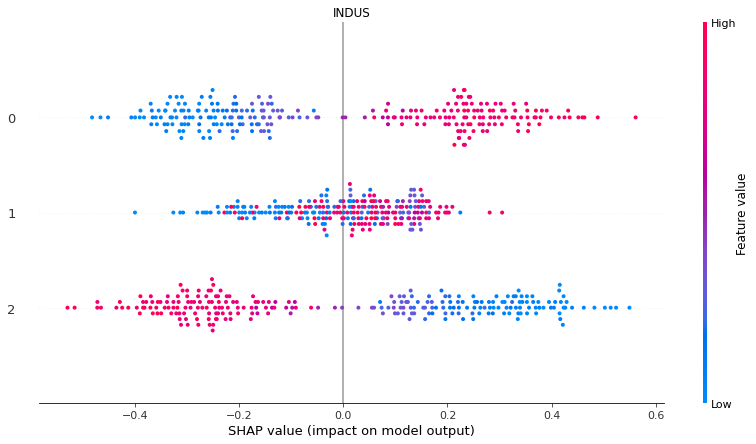

In [7]:
plot_feature_importance_scatter(explanations.log_odds[:, [feature_order[2]]], class_order=class_order)

This characteristic can be observed for other features as well, but not for all. E.g. for RAD, class 0 is indefinite and not class 1.

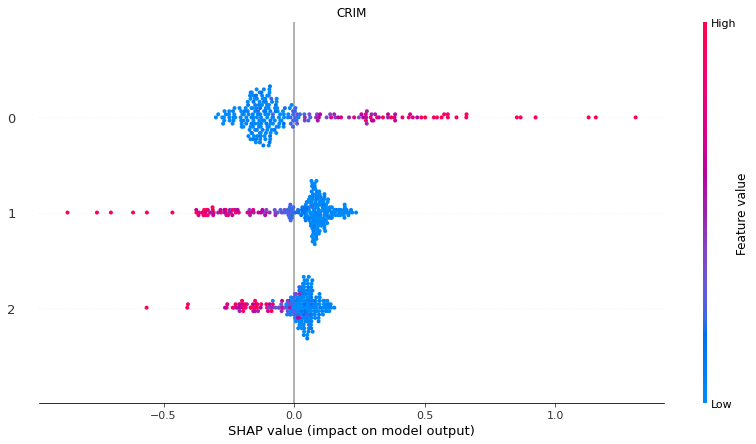

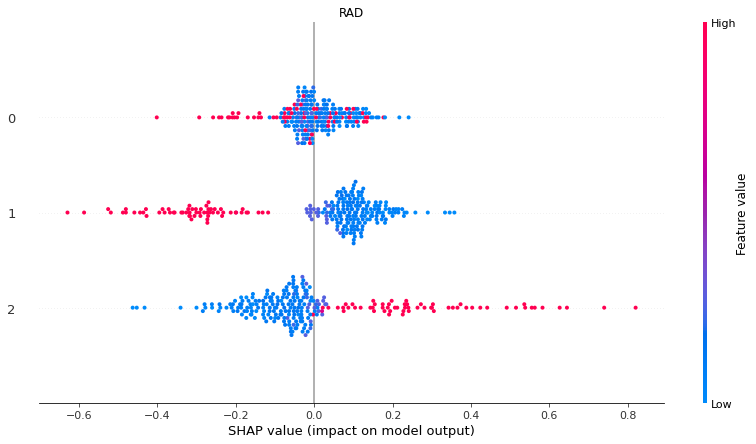

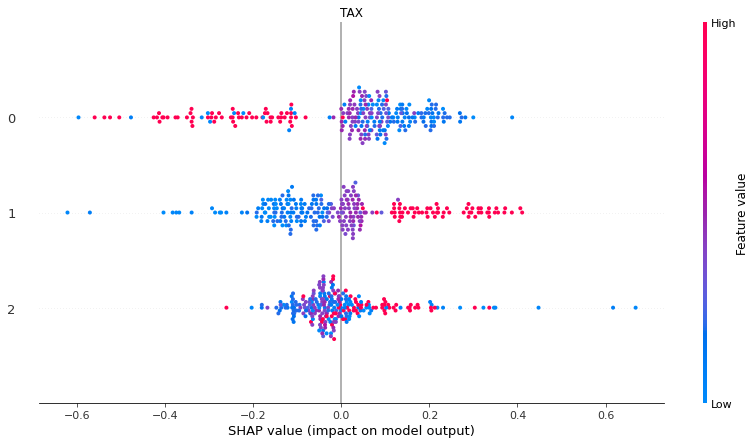

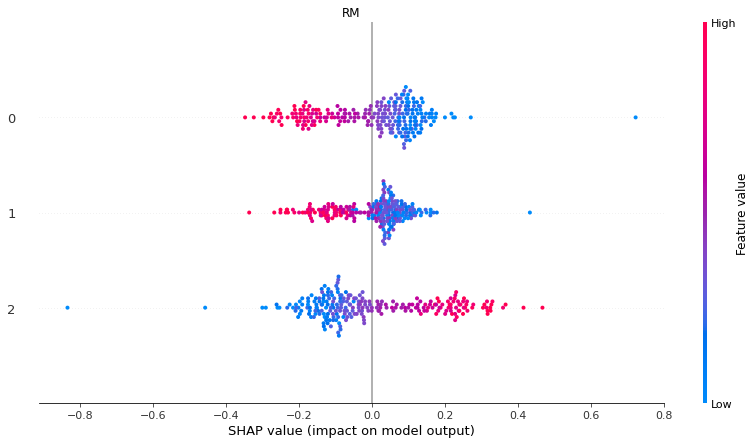

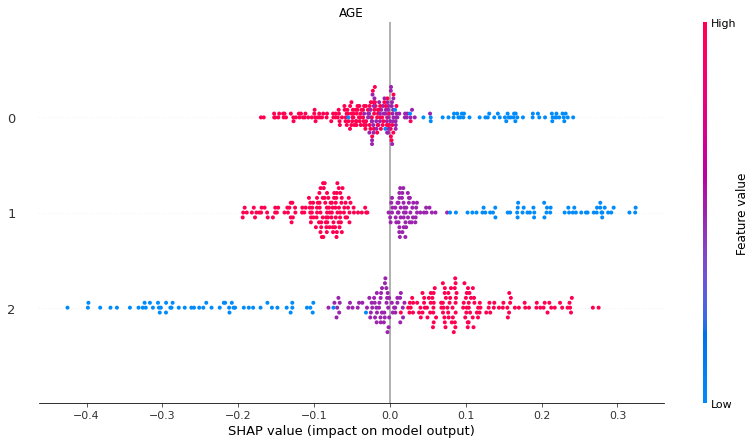

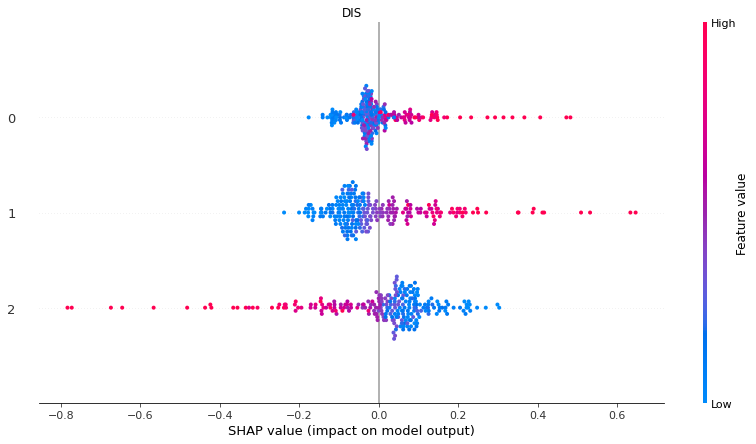

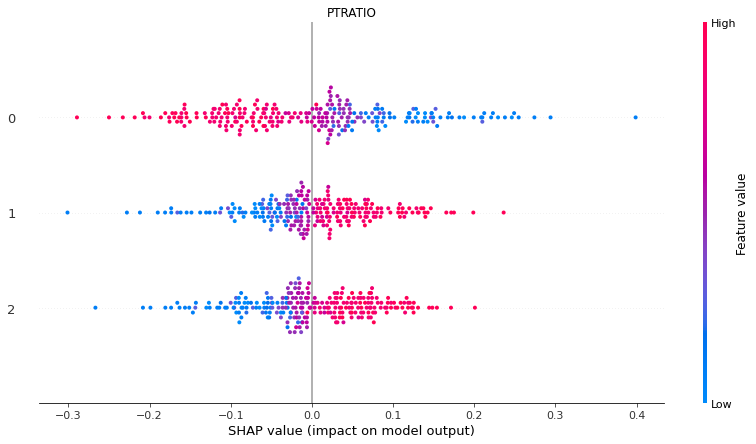

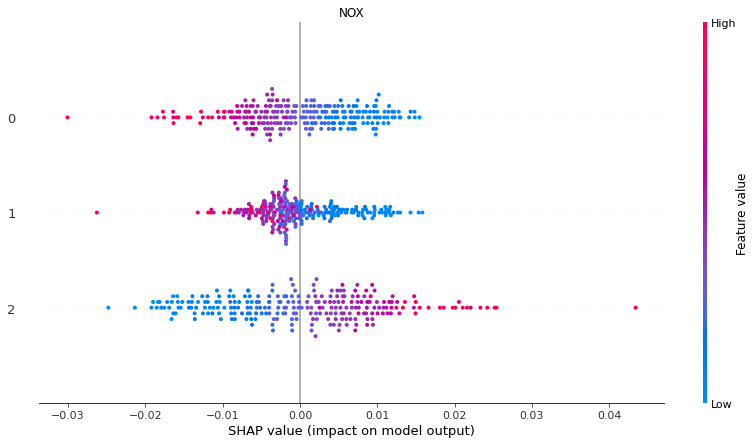

In [8]:
plot_feature_importance_scatter(explanations.log_odds[:, feature_order[3:]], class_order=class_order)

It might have been possible, to impose an order on the labels und create SHAP values for a regression task instead, but that would have simplified the problem and we would have missed, that there isn't always a strict ordering of the labels.

### Feature Effects

Plotting each feature's values against their SHAP values, we can visualize the marginal effect of each one, similar to partial dependence plots. We see, that for LSTAT, up until 20, there is a linear increase in log odds for class 0 (and a linear decrease for class 2) and then it flattens out, where there are only a few instances. The vertical dispersion shows, that there are interactions with other features. Class 1 has a smaller peak around 10-15. The other features mostly seem to have linear effects over the whole value range.

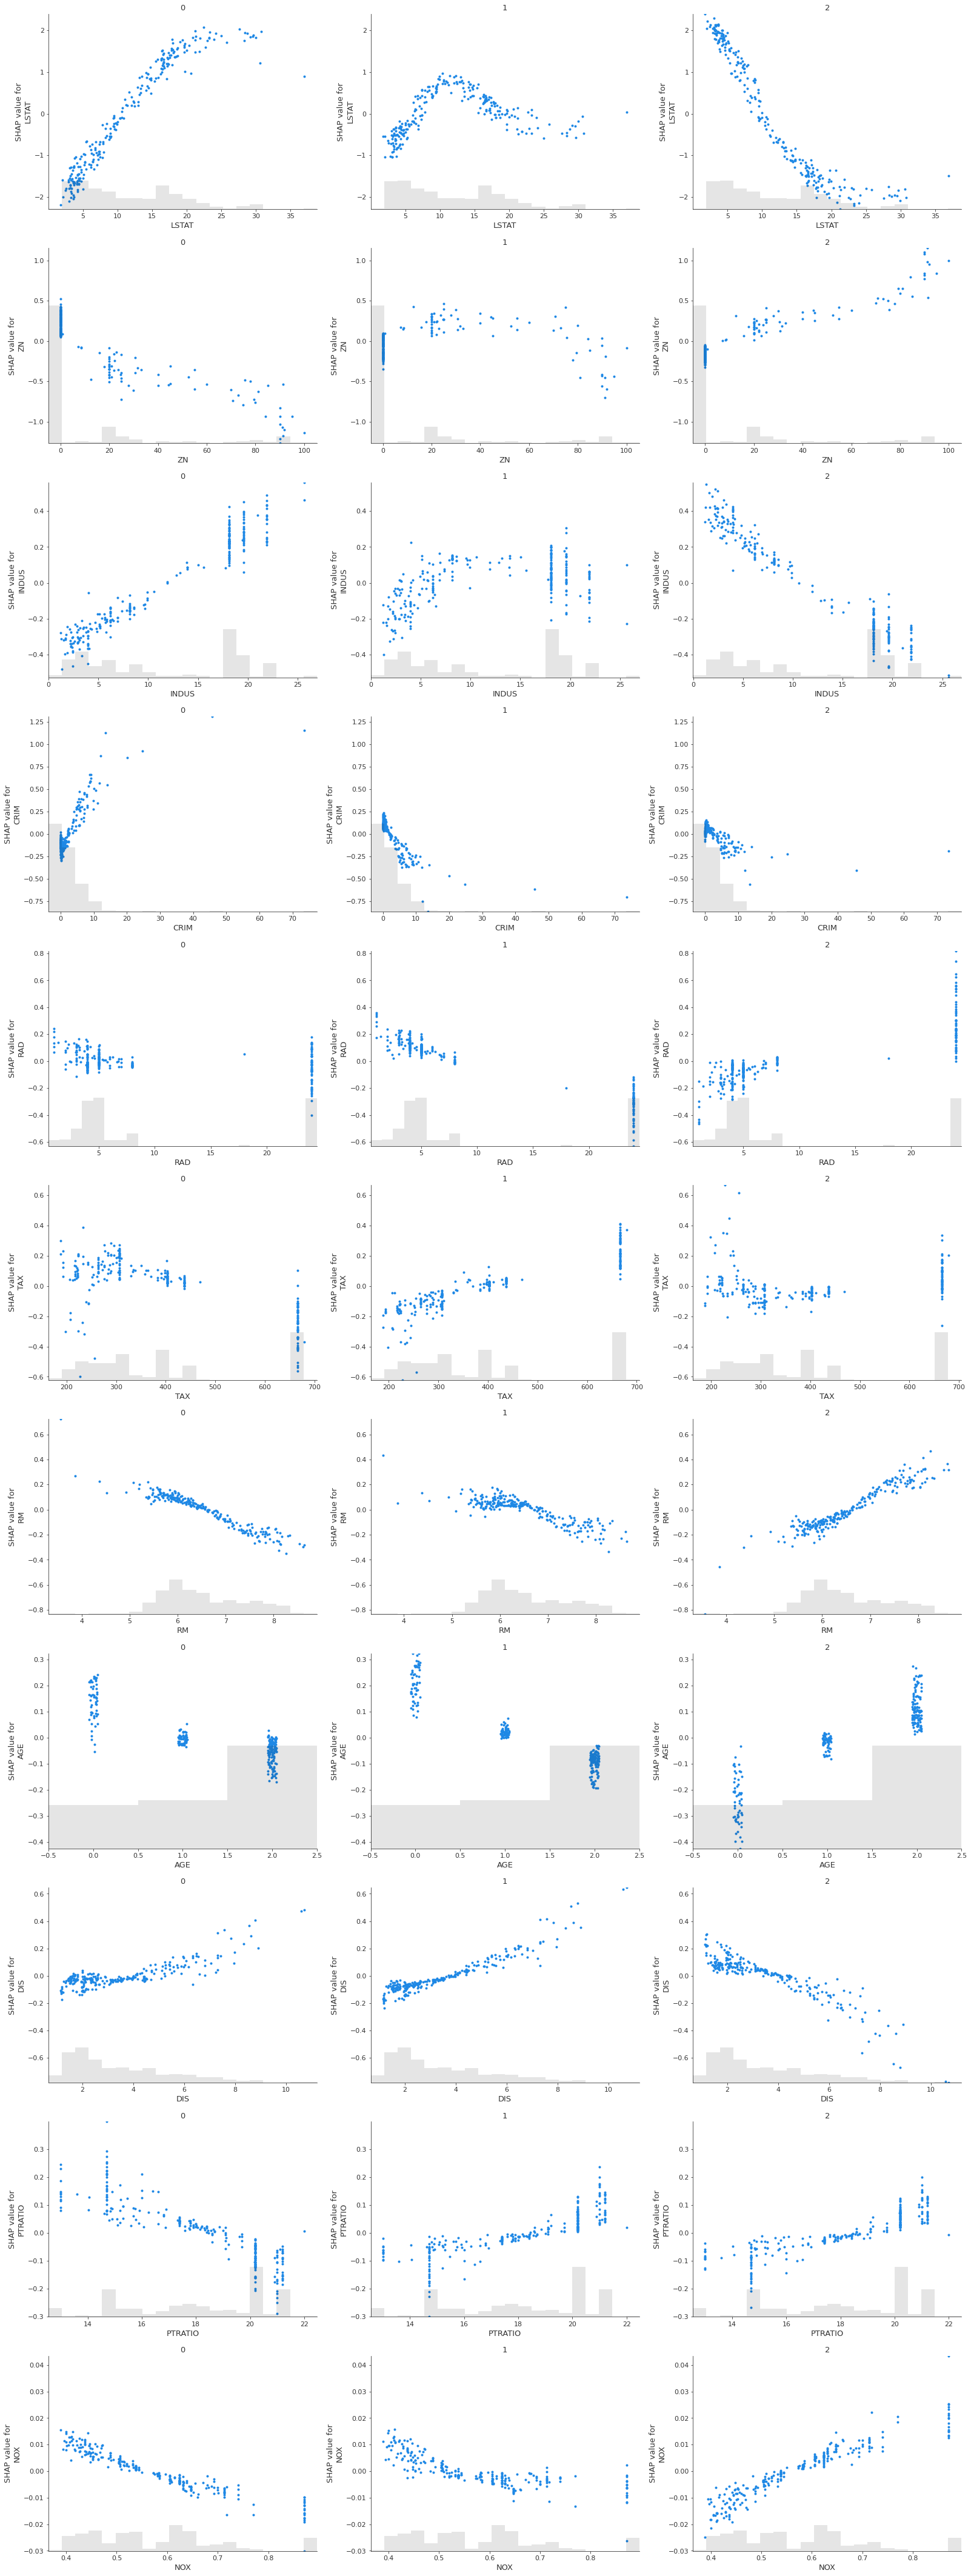

In [36]:
plot_feature_effects(explanations.log_odds[:, feature_order])

Now we plot all instances and their SHAP values at once, ordered by similarity (determined by hierarchical clustering). This time, we plot in probability space, to better see the resulting class probabilities. Most present, we see LSTAT as positive and negative forces. Interesting to note is, that the similarity sorting algorithm put first mainly instances classified as class 0, then in the middle those classified as 1 and to the right those classified as 2.

In [43]:
instance_order = calc_instance_order(explanations.log_odds)
plot_forces(explanations.log_odds, link='logit', instance_order=instance_order)